In [1]:
import torch
import torch.nn as nn
from torch.autograd.variable import Variable
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader

In [2]:
cd drive/My\ Drive/colab/vanilla_GAN

/content/drive/My Drive/colab/vanilla_GAN


In [3]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("device_count: {}".format(device_count))
    for device_num in range(device_count):
        print("device {} capability {}".format(
        	device_num,
            torch.cuda.get_device_capability(device_num)))
        print("device {} name {}".format(
	        device_num, torch.cuda.get_device_name(device_num)))
else:
  print("no cuda device")

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

device_count: 1
device 0 capability (3, 7)
device 0 name Tesla K80


In [4]:
train_loader = DataLoader(
    MNIST('./MNIST_DATA/', train=True, download=True,
          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.5,),(0.5, ))
          ])),
          batch_size=200, shuffle=True
)
test_loader = DataLoader(
    MNIST('./MNIST_DATA/', train=False, download=True,
          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(
                                  (0.5, ),(0.5, ))  
          ])),
          batch_size=200, shuffle=True
)

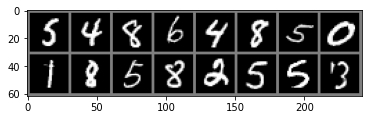

In [5]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img): 
    img = make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
example_mini_batch_img, example_mini_batch_label  = next(iter(train_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

In [6]:
d_noise  = 100
d_hidden = 256
batch_size = 200

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(d_noise, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden, 28*28),
            nn.Tanh()
        ).to(device)
    
    def forward(self, x):
        x = self.model(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(28*28, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(d_hidden, 1),
            nn.Sigmoid()
        ).to(device)
    
    def forward(self,x):
        x = self.model(x)
        return x

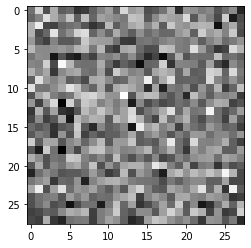

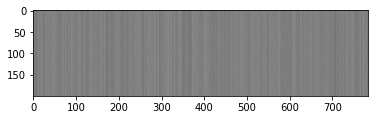

In [8]:
def makeNoise(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = Generator()
# 노이즈 생성하기
z = makeNoise()
# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch Size만큼 노이즈 생성하여 그리드로 출력하기
z = makeNoise(batch_size)
img_fake = G(z)
imshow_grid(img_fake)

In [9]:
D = Discriminator()

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.4979, 0.4986, 0.4972, 0.4979, 0.4990]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [10]:
class Loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCELoss()
    
    def forward(self, x, y):
        return self.loss(x, y)

In [11]:
def run_epoch(generator, discriminator, optimizer_g, optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(makeNoise(batch_size, d_noise)))

        loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + criterion(p_fake, torch.zeros_like(p_real).to(device))       
        
        loss_d.backward()
        optimizer_d.step()

        optimizer_g.zero_grad()

        p_fake = discriminator(generator(makeNoise(batch_size, d_noise)))      

        loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
        optimizer_g.step()
          
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(makeNoise(batch_size, d_noise)))).item())/10000.
            
    return p_real, p_fake

In [ ]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = torch.optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = torch.optim.Adam(D.parameters(), lr = 0.0002)

criterion = Loss()

p_real_trace = []
p_fake_trace = []

for epoch in range(200):
    
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(makeNoise(16)).view(-1, 1, 28, 28))

In [ ]:
plt.plot(avg_cost[0], label='D(x_generated)')
plt.plot(avg_cost[1] label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()